# Teleportación cuántica.

## Parte 1: Simulación.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

In [28]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

<IPython.core.display.Math object>

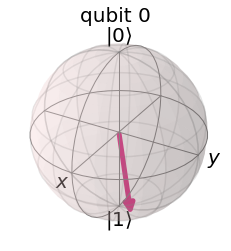

In [30]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")

# Show it on a Bloch sphere
plot_bloch_multivector(psi)


In [31]:
init_gate = Initialize(psi)
init_gate.label = "init"

In [32]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ 
                                             ║  ║    │   ┌──┴──┐
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞
                                             0  ║ ┌──┴──┐└─────┘
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════
                                                0 └─────┘

-------------------

## Simulación con Statevector:

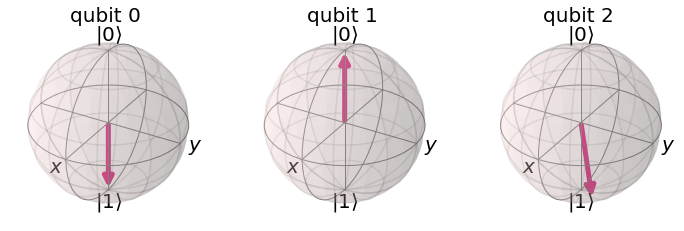

In [33]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

-------------------

-------------------

## Simulación con QSAM:

In [34]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [35]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─»
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ »
                                             ║  ║    │   ┌──┴──┐»
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞»
                                             0  ║ ┌──┴──┐└─────┘»
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════»
                                                0 └─────┘       »
«                       
«  q_0: ────────────────
«                       
«  q_1: ────────────────
«       ┌──────────────┐
«  q_2: ┤ disentangler ├
«       └──────────────┘
«crz: 1/════════════════
«                       
«crx: 1/════════════════
«

In [36]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()


┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─»
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ »
                                             ║  ║    │   ┌──┴──┐»
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞»
                                             0  ║ ┌──┴──┐└─────┘»
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════»
                                                0 └─────┘       »
 c0: 1/═════════════════════════════════════════════════════════»
                                                                »
«                          
«  q_0: ───────────────────
«                          
«  q_1: ───────────────────
«       ┌──────────────┐┌─┐
«  q_2: ┤ disentangler ├┤M├
«       └──────────────┘└╥┘
«crz: 1/═════════════════╬═
«                        ║ 
«crx: 1/═════════════════╬═
«                        ║ 
« c0: 1/═════════════════╩═
«                        0

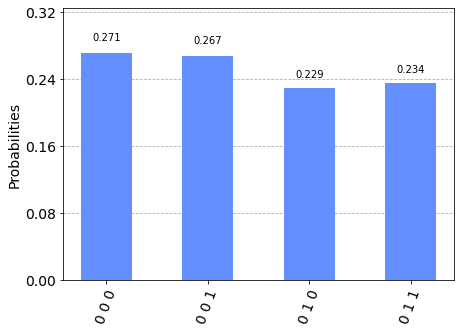

In [37]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the deferred measurement principle discussed in chapter 4.4 of [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

In [38]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)


In [39]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░───────■────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │                    
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░───■───┼────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ ┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░─┤ X ├─■─┤ disentangler ├┤M├
              ░      └───┘ ░            ░ └───┘   └──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0

In [ ]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell


In [ ]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)


In [ ]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")
 